# Report mAIstro

A simple agent for report generation based upon a user-supplied: 

* `Topic`: research topic
* `Structure`: report outline (can be natural langugae or a schema)

The agent solves a few problems: 

* `Section structure`: Users can describe what they want at varying levels of detail. On one extreme, a user may just descrbive the structure of the report in natural language. On the other extreme, the user may provide a JSON schema for the report. To handle these, report mAIstro will produce a plan for the report derived from the user input with each `Section` clearly defined.
* `Research vs distillation`: Some sections of a report require research (e.g., external sources such as web) whereas other sections (e.g., introduction or conclusion) are simply distillations of the report body. Report mAIstro will handle this, reflecting on which sections require research up-front and tacking those first.
* `Parallelization`: Research can be parallelized for an improved UX (lower latency). We use map-reduce to parallelize writing of every section that requires reseach first, and then - in parallel - writing any remaining sections of the report that need to be done. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use the web for research, but this could be easily customized (e.g., to use RAG, etc).

We'll use the [Tavily](https://tavily.com/) web search tool.

In [ ]:
_set_env("TAVILY_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [8]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "report-mAIstro"

## User inputs

Example user inputs: 

* Overall topic 
* Report schema, which can be a JSON object or simply a string description of the report organization

In [67]:
# Report topic 
topic = "Overview of AI Agent Frameworks."

# Test JSON schema input
report_structure_test_1 = {
  "report_sections": [
    {
      "name": "Executive Summary",
      "description": "A concise overview of the entire report's key findings and recommendations.",
    },
    {
      "name": "LangGraph Overview",
      "description": "Review of LangGraph as an agent framework. List the primary goals of the framework and provide a comprehensive summary of its key capabilities, features, and use cases."
    },
    {
      "name": "CrewAI",
      "description": "Review of CrewAI as an agent framework. List the primary goals of the framework and provide a comprehensive summary of its key capabilities, features, and use cases."
    },
    {
      "name": "OpenAI Swarm",
      "description": "Review of OpenAI Swarm as an agent framework. List the primary goals of the framework and provide a comprehensive summary of its key capabilities, features, and use cases."
    },
    {
      "name": "Summary",
      "description": "Summary of agent frameworks with comparative table of features."
    }
  ]
}

# Test natural language input
report_structure_test_2 = "Include sections on the following topics: LangGraph, CrewAI, OpenAI Swarm. In each section, simply list the goal of the framework and a summary of the framework's capabilities. Include an introduction and a concluding summary that contains a comparative table of features."

## Schemas

In [124]:
import operator
from typing_extensions import TypedDict
from typing import  Annotated, List
from pydantic import BaseModel, Field

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Goals for this section of the report.",
    )
    plan: str = Field(
        description="Organization for this section of the report, if supplied by the user, otherwise provide a reasonable and simple outline."
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    )   

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )

class ReportState(TypedDict):
    topic: str # Report topic
    report_structure: str # Report structure
    number_of_queries: int # Number web search queries to perform per section    
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report

class SectionState(TypedDict):
    number_of_queries: int # Number web search queries to perform per section 
    section: Section # Report section   
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

## Research plan generation

Look at the input schema, create a research plan for each section of the report based upon it.

Some sections (e.g., introduction and conclusion) may not require web research, as they will summarize or distill information from other sections.

In [63]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Prompt for research planning with an outline for each section of the report
report_planner_instructions="""Your goal is to generate an outline for a report on: 

{topic}

The report should follow the organization here: 

{report_organization}

Based upon the above report topic and the organization, for each section populate:

* name - Name for this section of the report
* description - Goals for this section of the report
* plan - Organization for this section of the report, if supplied by the user, otherwise provide a reasonable and simple outline.
* research - Whether to perform web research for this section of the report.
* content - The content of the section, which you will leave blank for now.

Consider which sections require web research. 

For example, introduction and conclusion will not require research because they will distill information from other parts of the report."""

def generate_report_plan(state: ReportState):

    # Inputs
    topic = state["topic"]
    report_structure = state["report_structure"]

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Format system instructions
    system_instructions = report_planner_instructions.format(topic=topic, report_organization=report_structure)

    # Generate question 
    structured_llm = llm.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate an outline for each section of the report.")])

    return {"sections": report_sections.sections}


In [ ]:
# Test with JSON input
sections = generate_report_plan({"topic": topic, "report_structure": report_structure_test_1})

In [ ]:
# Test with natural language input
sections = generate_report_plan({"topic": topic, "report_structure": report_structure_test_2})

## Web search and section writing

Perform web research for report sections that require it.

In [103]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

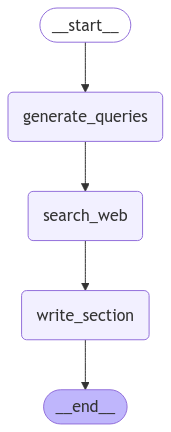

In [125]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Query writer instructions
query_writer_instructions="""Your goal is to generate queries for a web search.

Here is your topic: 

{section_topic}

Here is the organization of a report section on the topic: 

{section_plan}

Generate the following number of queries that capture unique and non-redundant information from the topic:

{number_of_queries}."""

# Section writer instructions
section_writer_instructions = """You are an expert technical writer. 
            
You are writing one section of a larger report based on a set of source documents about this overall topic: 
{section_topic}

1. Analyze the content of the source documents: 
- Each source document has content and url 
        
2. Create a report structure using markdown formatting:
- Use ## for the title
- Use ### for any sub-sections
- Use ### for the final section focused on sources
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the section, shown here:
{section_title}

5. Create compelling titles for sub-sections based on the outline here:
{section_plan}

6. Use this sources to fill in the details of the sub-sections: 
{context}

7. Final review:
- Ensure the report follows the sub-section structure
- Include no preamble before the title of the report
- Ensure that the section ends with sources"""

def deduplicate_and_format_sources(sources_list):
    """
    Takes a list or list of lists containing source dictionaries and returns
    a single list with unique elements based on URL.
    
    Args:
        sources_list: List or list of lists containing dictionaries with 'url' and 'content' keys
        
    Returns:
        List of unique source dictionaries, formatted string of sources 
    """
    # Flatten the list if it's a list of lists
    flat_list = []
    if isinstance(sources_list[0], list):
        for sublist in sources_list:
            flat_list.extend(sublist)
    else:
        flat_list = sources_list
    
    # Use a dictionary to keep track of unique URLs
    unique_sources = {}
    for source in flat_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Convert back to list
    sources_list = list(unique_sources.values())
    
    # Format
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(sources_list, 1):
        formatted_text += f"Source {i}:\n"
        formatted_text += f"URL: {source['url']}\n"
        formatted_text += f"Content: {source['content']}\n\n"
    
    return formatted_text.strip()

def generate_queries(state: SectionState):
    """ Generate search queries for a section """

    # Get state 
    number_of_queries = state["number_of_queries"]
    section = state["section"]

    # Generate queries 
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, section_plan=section.plan, number_of_queries=number_of_queries)

    # Generate queries  
    queries = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""
    
    # Get state 
    search_queries = state["search_queries"]

    # Search web 
    search_docs = tavily_search.batch([q.search_query for q in search_queries])

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs)

    return {"source_str": source_str}

def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state 
    section = state["section"]
    source_str = state["source_str"]

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, section_plan=section.plan, context=source_str)

    # Generate section  
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to the section object  
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

# Add nodes and edges 
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

# Compile
section_builder_graph = section_builder.compile()

# View
display(Image(section_builder_graph.get_graph(xray=1).draw_mermaid_png()))


In [ ]:
# Test with one section
sections['sections'][0]
completed_section = section_builder_graph.invoke({"section": sections['sections'][0], "number_of_queries": 2})

## Compile final report


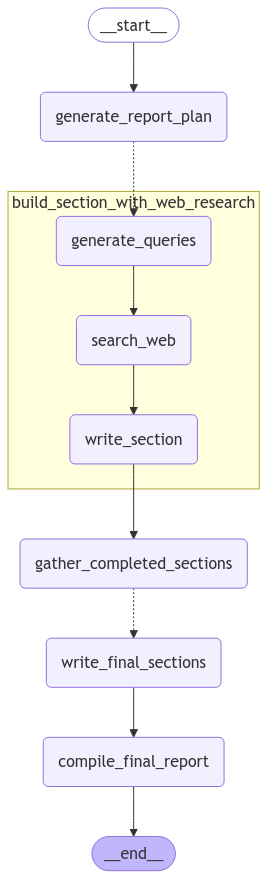

In [126]:
from langgraph.constants import Send

def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}

Plan:
{section.plan}

Requires Research: {section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str

final_section_writer_instructions="""You are an expert technical writer. 
            
You are writing one section of a larger report. Here is the section topic: 
{section_topic}

1. Analyze the content of the rest of the report, as you see here: 
{context}
        
2. Create your section formatting:
- Use # for overall report title if you are writing the introduction or start of the report
- Use ## for the title of the section
- Use ### for any sub-sections

3. Make your report title engaging based upon the focus area of the report.

4. Make your section title engaging based upon the focus area of the section, as shown here:
{section_title}

5. Create compelling titles for sub-sections based on the outline here:
{section_plan}

6. Final review:
- Ensure the section follows the sub-section structure
- Include no preamble before the title of the report"""

def initiate_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report """    

    # State
    number_of_queries = state["number_of_queries"]
    
    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("build_section_with_web_research", {"section": s, "number_of_queries": state["number_of_queries"]}) 
        for s in state["sections"] 
        if s.research
    ]

def write_final_sections(state: SectionState):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get state 
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    
    # Format system instructions
    system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, section_plan=section.plan, context=completed_report_sections)

    # Generate section  
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
        
    # Write content to section 
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """ TODO: Discuss this. Apparently needed as a reduce step. Gather completed section from research """    

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def initiate_final_section_writing(state: ReportState):
    """ This is the "map" step when we kick off research on any sections that require it using the Send API """    

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

def compile_final_report(state: ReportState):
    """ Write any final sections based the the rest of the report and compile the final report """    

    # Get sections
    sections = state["sections"]
    completed_sections = state["completed_sections"]

    # TODO: May not be needed, but for section order it may matter? 
    for completed in completed_sections:
        for section in sections:
            if section.name == completed.name:
                section.content = completed.content


    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

# Add nodes and edges 
builder = StateGraph(ReportState)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan", initiate_section_writing, ["build_section_with_web_research"])
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [127]:
final_state = graph.invoke({"topic": topic, "report_structure": report_structure_test_2, "number_of_queries": 2})

In [128]:
from IPython.display import Markdown
Markdown(final_state['final_report'])

## The Role of AI Agent Frameworks in Advancing Artificial Intelligence

### Defining AI Agent Frameworks

AI agent frameworks are structured environments or platforms that facilitate the development, coordination, and deployment of AI agents. These frameworks provide the necessary tools and infrastructure to create agents that can perform specific tasks autonomously or collaboratively. By offering predefined protocols and components, AI agent frameworks simplify the process of building complex AI systems, allowing developers to focus on the unique aspects of their applications rather than the underlying architecture.

### The Importance of AI Agent Frameworks in AI Development

AI agent frameworks play a crucial role in the advancement of artificial intelligence by enabling the creation of sophisticated, multi-agent systems. These frameworks allow for the seamless integration of various AI models and technologies, fostering innovation and efficiency in AI development. By providing a structured approach to agent coordination and task execution, AI agent frameworks help break down complex problems into manageable components, facilitating the development of robust and scalable AI solutions. Furthermore, they support the exploration of new AI paradigms, such as collaborative intelligence and decentralized systems, which are essential for tackling real-world challenges.

### Introducing Key AI Agent Frameworks: LangGraph, CrewAI, and OpenAI Swarm

In this report, we will explore three prominent AI agent frameworks that exemplify the diverse approaches to multi-agent orchestration and collaboration:

- **LangGraph**: This framework integrates language models with graph-based processing to create resilient language agents, enabling the development of complex AI workflows that handle intricate relationships and dependencies.

- **CrewAI**: Designed to orchestrate role-playing AI agents, CrewAI fosters collaborative intelligence by allowing agents to assume roles and work cohesively towards shared objectives, enhancing the efficiency of AI-driven processes.

- **OpenAI Swarm**: A flexible and scalable framework for decentralized multi-agent systems, OpenAI Swarm emphasizes lightweight orchestration and effective communication among agents, facilitating the development of sophisticated AI applications.

These frameworks highlight the innovative strategies being employed to push the boundaries of what AI can achieve, each offering unique capabilities and advantages that contribute to the field's ongoing evolution.

## LangGraph: Unleashing the Power of Language Agents

### Defining the Goal of LangGraph

LangGraph is an advanced AI workflow framework designed to integrate language models, graph-based processing, and workflow management into a cohesive platform. The primary goal of LangGraph is to build resilient language agents as graphs, enabling the development of complex AI workflows that can handle intricate relationships and dependencies. By defining clear goals and objectives, LangGraph ensures that AI agents' outputs align with user expectations, providing a structured approach to developing and deploying agentic applications (Source 1, Source 5).

### Exploring the Capabilities of LangGraph

LangGraph offers a robust framework for defining, coordinating, and executing multiple language model agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing multi-agent applications. This flexibility supports diverse control flows, including single agent, multi-agent, hierarchical, and sequential scenarios, making it suitable for handling realistic, complex situations (Source 2, Source 6). Additionally, LangGraph provides extensive customization options, allowing developers to build systems that can answer various types of questions and implement human-in-the-loop setups (Source 4).

### Unique Features and Advantages of LangGraph

One of the standout features of LangGraph is its ability to integrate language models with graph-based structures, offering a powerful combination for AI workflow management. This integration allows LangGraph to handle complex relationships and dependencies within AI workflows, making it a significant advancement in the field. The framework also ensures reliability with easy-to-add moderation and quality loops, preventing agents from veering off course. Furthermore, LangGraph's platform supports the templatization of cognitive workflows, facilitating automated deployment and monitoring of AI models (Source 5, Source 6).

### Sources

1. [AI Agents in LangGraph](https://www.rapidinnovation.io/post/ai-agents-in-langgraph)
2. [LangGraph Tutorial](https://www.datacamp.com/tutorial/langgraph-tutorial)
3. [GitHub - langchain-ai/langgraph](https://github.com/langchain-ai/langgraph)
4. [Exploring LangGraph](https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787)
5. [LangGraph: A Detailed Technical Exploration](https://www.linkedin.com/pulse/langgraph-detailed-technical-exploration-ai-workflow-jagadeesan-n9woc)
6. [LangGraph Overview](https://www.langchain.com/langgraph)

## CrewAI: Revolutionizing AI Collaboration

### The Goal of CrewAI

CrewAI is a cutting-edge, open-source framework designed to orchestrate role-playing AI agents, enabling them to work cohesively towards shared objectives. The primary goal of CrewAI is to foster collaborative intelligence by empowering autonomous AI agents to assume roles, share goals, and operate as a cohesive unit, much like a well-oiled crew. This framework is designed to enhance the efficiency and effectiveness of AI-driven processes by facilitating the collaboration of agents, each assigned specific roles and responsibilities.

### Capabilities of CrewAI

CrewAI offers a transformative approach to multi-agent orchestration, allowing AI agents to tackle complex tasks through a structured process. The framework enables real-time collaboration among multiple agents, reducing costs and improving operational efficiency across various sectors. CrewAI's capabilities include:

- **Role-Based Agent Design**: Users can customize agents with specific roles, goals, and tools, enabling them to operate cohesively.
- **Autonomous Inter-Agent Delegation**: Agents can autonomously delegate tasks and inquire amongst themselves, enhancing problem-solving efficiency.
- **Flexible Task Management**: Users can define tasks with customizable tools and assign them dynamically to agents, providing the flexibility needed for various project requirements.
- **Custom GPT Integration**: CrewAI's custom GPT facilitates interactive queries about the platform's features, offering an intuitive user experience.

### Distinctive Features and Benefits

CrewAI stands out in the AI industry due to its innovative approach to AI collaboration and its user-friendly interface. Some of its distinctive features and benefits include:

- **Hierarchical Process Management**: CrewAI employs an autonomously generated manager agent that oversees the execution and allocation of tasks, exemplifying autonomous and collaborative task completion.
- **Versatile Integration**: The framework can seamlessly integrate into existing work environments, such as updating colleagues on Slack or creating email automations.
- **Open-Source Accessibility**: CrewAI's open-source nature makes it accessible to both seasoned experts and beginners, solidifying its position as a leading solution in the AI industry.

### Sources

- [CrewAI GitHub Repository](https://github.com/crewAIInc/crewAI)
- [CrewAI Guide on CodeGPT](https://insights.codegpt.co/crewai-guide)
- [IBM Think on CrewAI](https://www.ibm.com/think/topics/crew-ai)
- [XTimes Substack on CrewAI](https://xtimes.substack.com/p/crewai-a-promising-multiagent-framework)
- [XTimes Medium on CrewAI](https://xtimes.medium.com/crewai-a-promising-multiagent-framework-2413be409067)

## OpenAI Swarm: Revolutionizing Multi-Agent AI Systems

### The Goal of OpenAI Swarm
OpenAI Swarm is designed to provide a flexible and scalable framework for decentralized multi-agent systems. Its primary goal is to enable seamless coordination and execution of multiple AI agents within a single environment. By offering an adaptable platform, Swarm allows AI agents to focus on specialized tasks while maintaining effective communication with their counterparts, much like a well-organized company where different departments handle specific responsibilities. This approach aims to break down complex problems into manageable components, facilitating the development of sophisticated yet maintainable AI systems.

### Capabilities of OpenAI Swarm
Swarm's architecture is built to support the creation of intricate AI applications with unprecedented ease. It emphasizes simplicity, control, and clear patterns for agent coordination, making it an ideal choice for building multi-agent systems. Swarm is not just an all-encompassing solution but an experimental, educational framework that encourages exploration of lightweight multi-agent orchestration. Its capabilities have been demonstrated in real-world applications, such as a leading travel company using Swarm to create personalized travel itineraries, showcasing its potential to enhance customer experiences by providing tailored recommendations.

### Special Characteristics and Strengths
One of the standout features of OpenAI Swarm is its open-source nature, which empowers developers to innovate and build complex AI applications. Swarm distinguishes itself from other frameworks by offering a decentralized approach to multi-agent coordination, which is both scalable and adaptable to real-world scenarios. Its strength lies in its ability to streamline the orchestration of AI agents, significantly reducing response times and improving efficiency in applications like customer service. By focusing on lightweight orchestration, Swarm provides a powerful yet maintainable solution for developing advanced AI systems.

### Sources
- [A Deep Dive into OpenAI’s Swarm Framework: The Future of Multi-Agent AI Systems](https://medium.com/@hybrid.minds/a-deep-dive-into-openais-swarm-framework-the-future-of-multi-agent-ai-systems-c00e395be1b3)
- [Understanding OpenAI Swarm: A Framework for Multi-Agent Systems](https://lablab.ai/blog/understanding-openai-swarm-a-framework-for-multi-agent-systems)
- [Hands-On with OpenAI Swarm](https://towardsdatascience.com/hands-on-with-openai-swam-bbbffaa833e5)
- [OpenAI Swarm Guide](https://insights.codegpt.co/openai-swarm-guide)

## Comparative Analysis of AI Frameworks: LangGraph, CrewAI, and OpenAI Swarm

### Recap of Goals and Capabilities

In this section, we revisit the primary goals and capabilities of the three AI frameworks discussed in the report: LangGraph, CrewAI, and OpenAI Swarm.

- **LangGraph** aims to integrate language models with graph-based processing to create resilient language agents. Its capabilities include defining and executing complex AI workflows with diverse control flows, supporting multi-agent applications, and offering extensive customization options.

- **CrewAI** focuses on orchestrating role-playing AI agents to work collaboratively towards shared objectives. It provides real-time collaboration, role-based agent design, and flexible task management, enhancing the efficiency of AI-driven processes.

- **OpenAI Swarm** is designed for decentralized multi-agent systems, enabling seamless coordination and execution of AI agents. It emphasizes simplicity and control, supporting the development of sophisticated AI applications with a focus on lightweight orchestration.

### Comparative Table of Features

| Feature/Framework | LangGraph | CrewAI | OpenAI Swarm |
|-------------------|-----------|--------|--------------|
| **Integration**   | Language models with graph-based structures | Role-based agent design | Decentralized multi-agent coordination |
| **Customization** | Extensive options for agent workflows | Customizable tools and tasks | Open-source for innovation |
| **Collaboration** | Multi-agent and hierarchical scenarios | Real-time inter-agent delegation | Scalable and adaptable coordination |
| **Unique Strengths** | Templatization of cognitive workflows | Hierarchical process management | Lightweight orchestration for efficiency |

### Insights on Framework Selection

When selecting an AI framework, it is crucial to consider the specific needs and objectives of your project. LangGraph is ideal for projects requiring complex language model integration and workflow management. CrewAI is best suited for scenarios where collaborative intelligence and role-based agent orchestration are paramount. OpenAI Swarm is the go-to choice for projects that benefit from decentralized, scalable multi-agent systems with a focus on simplicity and control. Each framework offers unique strengths that cater to different aspects of AI development, making them valuable tools in the AI industry.

Trace: 

https://smith.langchain.com/public/9a31adf0-3742-48c1-a8ab-09101da752d8/r